# Part 2: Predicting Precipitation in San Jose, CA - Modeling
This project is an extension from the Random Forest challenge in Module 22. After modeling the data using a random forest algorithm, I will also use a neural network and compare the results.

In [1]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sqlalchemy import create_engine
import time
import warnings
warnings.filterwarnings('ignore')

import helpers as hp
from config import usr, pwd, url, port, db, table

%matplotlib inline

/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-

## Load Dataset
Read that data from a SQL database and load into a Pandas `DataFrame`.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {table};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

In [6]:
df_model = df.copy()

## EDA
This will include data exploration and feature engineering.

### Irrelevant Columns
Drop irrelevant columns from the dataset. These are either redundant or do not apply to San Jose, CA.

In [7]:
features_to_drop = ['DailyDepartureFromNormalAverageTemperature', 
                    'DailyMaximumDryBulbTemperature', 
                    'DailyMinimumDryBulbTemperature', 
                    'DailySnowDepth', 
                    'DailySnowfall']
df_model.drop(features_to_drop, axis=1, inplace=True)

### Additional Features
#### Create _DayDuration_ feature
Subtract _sunset_ from _sunrise_ to create _DayDuration_. Then, remove the columns _sunset_ and _sunrise_.

In [8]:
df_model['DayDuration'] = df_model['Sunset'] - df_model['Sunrise']
df_model.drop(['Sunset', 'Sunrise'], axis=1, inplace=True)

#### Create _PrecipitationChance_ feature
Create a new column, _PrecipitationChance_. Base this off _DailyWeather_. If _DailyWeather_ equals Unknown, then set _PrecipitionChance_ equal to zero.

In [9]:
df_model['PrecipitationChance'] = np.zeros(len(df_model))

In [10]:
def find_keywords(x):
    value = 0
    precipitation_keywords = ['GR', 'DZ', 'RA', 'UP']
    for keyword in precipitation_keywords:
        if keyword in x:
            value = 1
    return value

In [11]:
df_model['PrecipitationChance'] = df_model['DailyWeather'].apply(lambda x: find_keywords(x))
df_model.drop(['DailyWeather'], axis=1, inplace=True)

### Correlated features
Remove correlated features.

In [12]:
features = df_model.columns.tolist()
features.remove('PrecipitationChance')

In [13]:
correlated_features = hp.find_correlated_features(df_model, thresh=0.8)

Correlated Columns (r > 0.8):
* DailyAverageStationPressure
* DailyAverageWetBulbTemperature
* DailyHeatingDegreeDays
* DailyPeakWindSpeed
* DailySustainedWindSpeed
5 correlated features will be removed.


In [14]:
df_model.drop(correlated_features, axis=1, inplace=True)

In [15]:
uncorrelated_features = df_model.columns.tolist()
uncorrelated_features.remove('PrecipitationChance')

In [16]:
df_corr = df_model.loc[:, uncorrelated_features].corr()

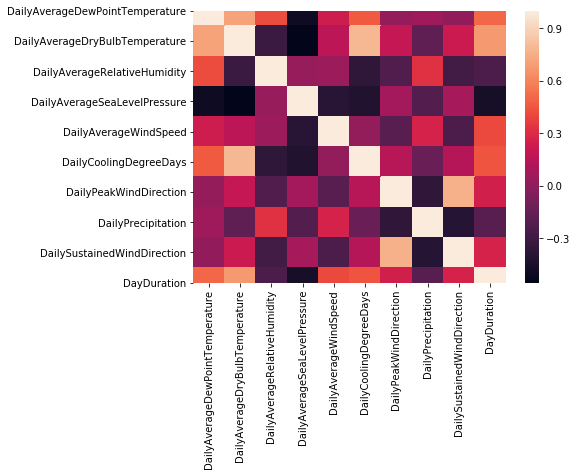

In [17]:
f, axes = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(df_corr, ax=axes)
plt.show()

### Features and target
Split dataset into features and target variables.

In [18]:
X = df_model.drop('PrecipitationChance', axis=1)
y = df_model['PrecipitationChance']

### Train-test split
Split features and target variables into train and test sets.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Class imbalance
Let's view the class proportions for the target variable.

In [20]:
y_train.value_counts()

0    1338
1     280
Name: PrecipitationChance, dtype: int64

There are many more values for class 0 than for class 1. I will use the `SMOTE` algorithm to correct for this class imbalance.

In [21]:
X_upsampled, y_upsampled = SMOTE().fit_resample(X_train, y_train)

In [22]:
pd.Series(y_upsampled).value_counts()

1    1338
0    1338
dtype: int64

Good. Now I have equal class amounts.

## Modeling
### Model 1: Random Forest

In [23]:
hp.rfc_params['n_estimators'] = 400
hp.rfc_params['max_depth'] = 3

In [24]:
pprint(hp.rfc_params)

{'max_depth': 3, 'n_estimators': 400}


In [25]:
hp.run_random_forest_model(X_upsampled, X_test, y_upsampled, y_test, num_folds=5, evaluate_model=True)

Random Forest Model
 * training score: 0.979
 * mean CV score: 0.976
 * std CV score: 0.009
 * test score: 0.972


### Model 2: MLPClassifier

In [29]:
hp.mlp_params['hidden_layer_sizes'] = (1000, )
hp.mlp_params['activation'] = 'relu'
hp.mlp_params['solver'] = 'adam'
hp.mlp_params['learning_rate_init'] = 0.001

In [30]:
pprint(hp.mlp_params)

{'activation': 'relu',
 'hidden_layer_sizes': (1000,),
 'learning_rate_init': 0.001,
 'solver': 'adam'}


In [31]:
hp.run_mlp_model(X_upsampled, X_test, y_upsampled, y_test, num_folds=5, evaluate_model=True)

MLP Model
 * training score: 0.850
 * mean CV score: 0.842
 * std CV score: 0.015
 * test score: 0.928
